In [18]:
import torch
import torch.nn as nn 
import torch.nn.functional as f 
from sklearn.model_selection import train_test_split 
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib_inline
import scipy.stats as stats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [19]:
data = pd.read_csv('mnist_train.csv')
data = data.values

In [20]:
labels = data[:,0]
data = data[:,1:]


In [21]:
# converting data to tensor
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).long()

# train and test Split
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .2)


# normalizing

## 0
train_data = train_data/torch.max(train_data)
test_data = test_data/torch.max(test_data)



print(f"The range of train_data is {torch.min(train_data)} : {torch.max(train_data)}")
print(f"The range of test_data is {torch.min(test_data)} : {torch.max(test_data)}")

# Tensor dataset
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Data Loaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))




The range of train_data is 0.0 : 1.0
The range of test_data is 0.0 : 1.0


In [22]:
def createMNISTnet():

    class MNISTnet(nn.Module):
        

        def __init__(self):
            super().__init__()

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layer 
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):

            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return self.output(X)
        
    
    net = MNISTnet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer 
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer     


In [23]:
net = createMNISTnet()[0]
print("Summary of the model : ")
print(net)
print(' ')

Summary of the model : 
MNISTnet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
 


In [24]:
# explore one of the layers 
print('Summary of the input layer ')
print(vars(net.input))
print(' ')

Summary of the input layer 
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[-0.0314,  0.0331, -0.0075,  ..., -0.0216,  0.0109,  0.0241],
        [-0.0007,  0.0098,  0.0054,  ..., -0.0259,  0.0248, -0.0161],
        [ 0.0119,  0.0245, -0.0097,  ...,  0.0219,  0.0334,  0.0134],
        ...,
        [-0.0081, -0.0225, -0.0220,  ...,  0.0153,  0.0060, -0.0099],
        [ 0.0087, -0.0222, -0.0082,  ..., -0.0189,  0.0014, -0.0026],
        [ 0.0231,  0.0062, -0.0258,  ..., -0.0337,  0.0262, -0.0316]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.0356,  0.0212, -0.0218,  0.0134,  0.0040, -0.0115,  0.0188, -0.0276,
         0.0269, -0.0303, -0.0253,  0.0353,  0.0017,  0.0295,  0.0079,  0.0307,
        -0.0308, -0.0119, -0.0039, -0.0226,  0.0010,  0.0310,  0.0320, -0.0344,
         0.0035,  0.0176, -0.0039, -0.0247, -0.0357, -0.0284, -0.0142,  0.0011,
        -0.0031,  0.0357, -0.0136, -0.0239,  0.0112,  0.0124,  0.0324,  0.0298

In [25]:
# check out the matrix of weights 
print('Input layer weights: ')
print(net.input.weight.shape)
print(net.input.weight)
print(' ')

Input layer weights: 
torch.Size([64, 784])
Parameter containing:
tensor([[-0.0314,  0.0331, -0.0075,  ..., -0.0216,  0.0109,  0.0241],
        [-0.0007,  0.0098,  0.0054,  ..., -0.0259,  0.0248, -0.0161],
        [ 0.0119,  0.0245, -0.0097,  ...,  0.0219,  0.0334,  0.0134],
        ...,
        [-0.0081, -0.0225, -0.0220,  ...,  0.0153,  0.0060, -0.0099],
        [ 0.0087, -0.0222, -0.0082,  ..., -0.0189,  0.0014, -0.0026],
        [ 0.0231,  0.0062, -0.0258,  ..., -0.0337,  0.0262, -0.0316]],
       requires_grad=True)
 


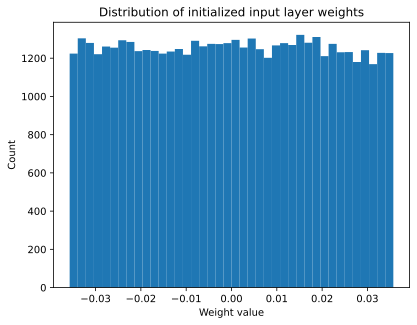

In [26]:
# histogram
w = net.input.weight.detach().flatten()
plt.hist(w, 40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized input layer weights')
plt.show()

In [27]:
def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])
  
  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy

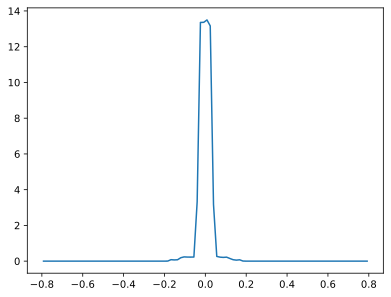

In [28]:
histx,histy = weightsHistogram(net)
plt.plot(histx, histy)


In [29]:
def function2TrainTheModel():

    numepochs = 60

    net, lossfun, optimizer = createMNISTnet()

    losses = np.zeros(numepochs)
    testAcc = []
    trainAcc = []
    histx = np.zeros((numepochs, 100))
    histy = np.zeros((numepochs, 100))

    for epochi in range(numepochs):

        # get the weights distribution at the start of this epoch
        histx, histy[epochi, :] = weightsHistogram(net)

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculating accuracy 
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)

        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)


    return trainAcc, testAcc, losses, net, histx, histy





In [30]:
trainAcc, testAcc, losses, net, histx, histy = function2TrainTheModel()

Text(0.5, 1.0, 'Model Accuracy')

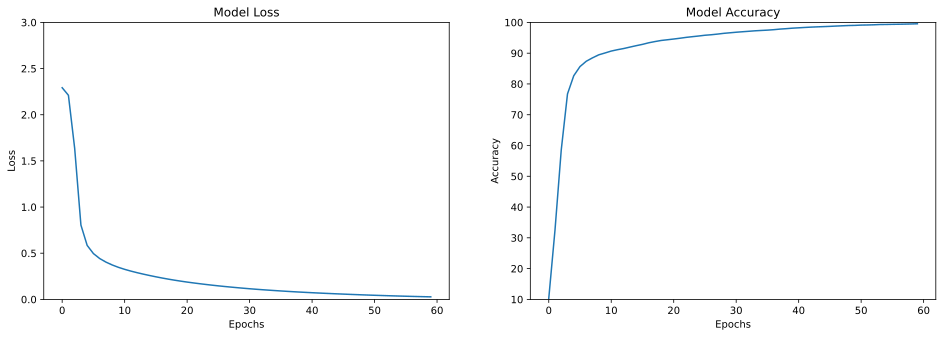

In [31]:
fig, ax = plt.subplots(1,2, figsize = (16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'train')
ax[1].plot(testAcc, label = 'test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([10,100])
ax[1].set_title('Model Accuracy')


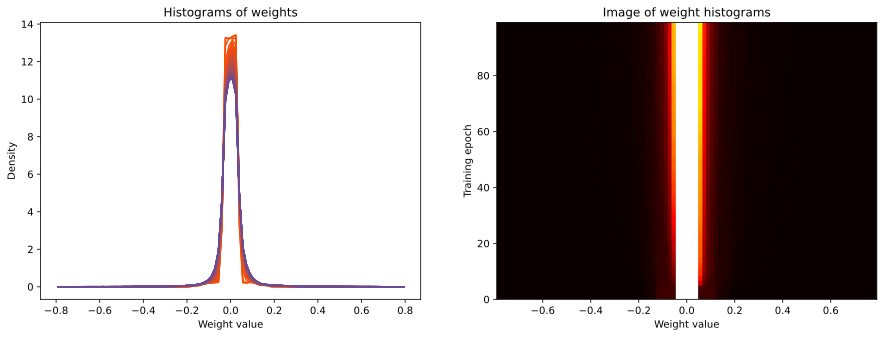

In [32]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()